In [1]:
pip install yfinance numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [117]:
pip install arch


  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/6b/a7/20b3f209b55a862f6ff0ec508d158a12c6e7eb9b62cfa839822eafcc0214/arch-7.2.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/927.1 kB ? eta -:--:--
   --------- ------------------------------ 215.0/927.1 kB 6.6 MB/s eta 0:00:01
   -------------------- ------------------- 481.3/927.1 kB 6.0 MB/s eta 0:00:01
   --------------------------------- ------ 768.0/927.1 kB 6.1 MB/s eta 0:00:01
   ---------------------------------------  921.6/927.1 kB 5.8 MB/s eta 0:00:01
   ---------------------------------------- 927.1/927.1 kB 5.3 MB/s eta 0:00:00


In [17]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Mean of daily returns: 0.0018124480592667167
Std of daily returns: 0.012565588337602261
Last historical close price: Ticker
AAPL    192.529999
Name: 2023-12-29 00:00:00, dtype: float64
Avg final simulated price: 303.0763898720642
Median final simulated price: 297.778120079486
Min final simulated price: 136.12672058335423
Max final simulated price: 557.3296448440946


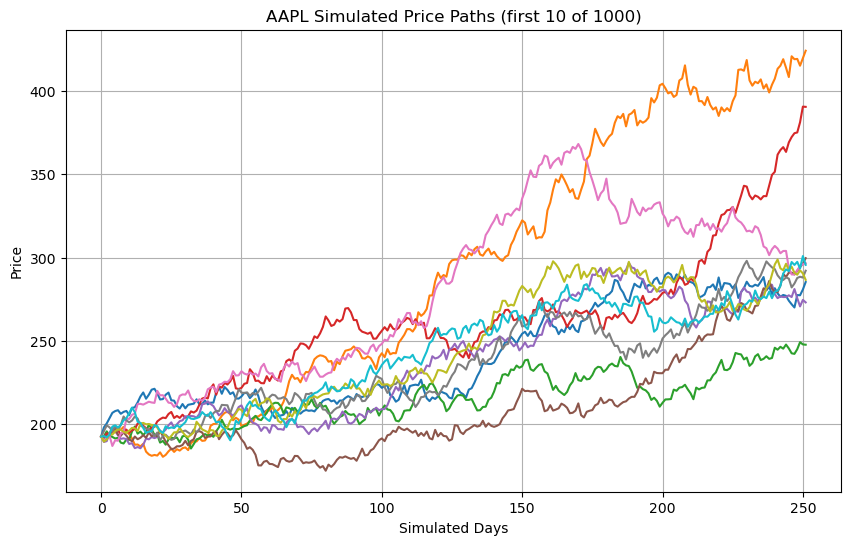

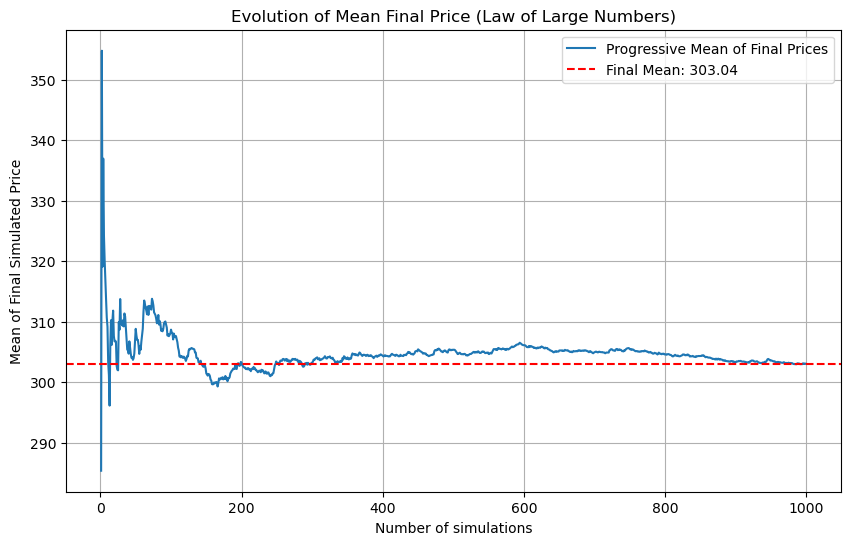

In [44]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_stock_brownian_motion(
    ticker="AAPL", 
    start_date="2023-01-01", 
    end_date="2023-12-31", 
    num_simulations=1000,
    days_to_simulate=252
):
    """
    Fetches historical stock data for the given ticker and date range using yfinance,
    computes daily returns, and simulates possible future price evolution 
    using a Geometric Brownian Motion model.
    
    Args:
        ticker (str): Stock ticker (default is "AAPL").
        start_date (str): Start date for historical data in "YYYY-MM-DD" format.
        end_date (str): End date for historical data in "YYYY-MM-DD" format.
        num_simulations (int): Number of Brownian motion simulations to run.
        days_to_simulate (int): Number of trading days to simulate (default 252 ~ 1 year).

    Returns:
        price_paths (ndarray): A 2D array of simulated prices of shape 
                               (days_to_simulate, num_simulations).
        summary_stats (dict): Dictionary of summary statistics and insights.
    """
    
    # 1. Fetch historical data
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Basic error handling in case data retrieval fails or is empty
    if data.empty:
        raise ValueError(f"No data returned for {ticker} in the given date range.")
    
    # 2. Compute daily returns
    data['Daily_Returns'] = data['Close'].pct_change()
    data.dropna(inplace=True)  # remove the first NaN
    
    # Mean and standard deviation of daily returns
    mu = data['Daily_Returns'].mean()
    sigma = data['Daily_Returns'].std()
    
    # 3. Set the initial price as the last available Close price in the fetched dataset
    last_price = data['Close'].iloc[-1]

    # 4. Simulate the Geometric Brownian Motion paths
    #    S(t+1) = S(t) * exp( (mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z )
    #    where Z ~ N(0, 1)
    dt = 1.0  # 1 day time-step (in "trading day" units)
    
    # Initialize array to store simulated prices
    price_paths = np.zeros((days_to_simulate, num_simulations))
    price_paths[0, :] = last_price
    
    # Generate paths
    for t in range(1, days_to_simulate):
        Z = np.random.standard_normal(num_simulations)  # draw random normal values
        # Compute the price for day t using GBM formula
        price_paths[t, :] = price_paths[t - 1, :] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        )

    # 5. Summarize results
    # Example: final day distribution, average final price, min, max, etc.
    final_prices = price_paths[-1, :]
    avg_final_price = np.mean(final_prices)
    median_final_price = np.median(final_prices)
    min_final_price = np.min(final_prices)
    max_final_price = np.max(final_prices)

    # Illustrate the Law of Large Numbers: 
    # The mean of simulated final prices should stabilize around E[S(T)] with large # of simulations
    # The theoretical expected multiplier after T days would be exp(mu*T).
    # For demonstration, we record the progressive average of final prices as the run count increases.
    progressive_mean = [
        np.mean(final_prices[:i]) if i > 0 else np.nan
        for i in range(num_simulations)
    ]

    summary_stats = {
        "Mean of daily returns": mu,
        "Std of daily returns": sigma,
        "Last historical close price": last_price,
        "Avg final simulated price": avg_final_price,
        "Median final simulated price": median_final_price,
        "Min final simulated price": min_final_price,
        "Max final simulated price": max_final_price,
        "Progressive mean (law of large numbers)": progressive_mean
    }
    
    return price_paths, summary_stats


if __name__ == "__main__":
    # Example usage
    # ------------------------
    # Simulate 1000 paths for 252 trading days ~ 1 year
    # ------------------------
    paths, stats = simulate_stock_brownian_motion(
        ticker="AAPL", 
        start_date="2023-01-01", 
        end_date="2023-12-31", 
        num_simulations=1000, 
        days_to_simulate=252
    )
    
    # Print summary statistics
    for k, v in stats.items():
        if k != "Progressive mean (law of large numbers)":
            print(f"{k}: {v}")

    # Plot a handful of simulated paths to visualize
    plt.figure(figsize=(10, 6))
    plt.plot(paths[:, :10])  # plot only first 10 to avoid clutter
    plt.title("AAPL Simulated Price Paths (first 10 of 1000)")
    plt.xlabel("Simulated Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

    # Plot how the mean of the final price evolves with the number of simulations
    progressive_mean = stats["Progressive mean (law of large numbers)"]
    plt.figure(figsize=(10, 6))
    plt.plot(progressive_mean, label="Progressive Mean of Final Prices")
    plt.axhline(y=progressive_mean[-1], color='r', linestyle='--', 
                label=f"Final Mean: {progressive_mean[-1]:.2f}")
    plt.title("Evolution of Mean Final Price (Law of Large Numbers)")
    plt.xlabel("Number of simulations")
    plt.ylabel("Mean of Final Simulated Price")
    plt.legend()
    plt.grid(True)
    plt.show()


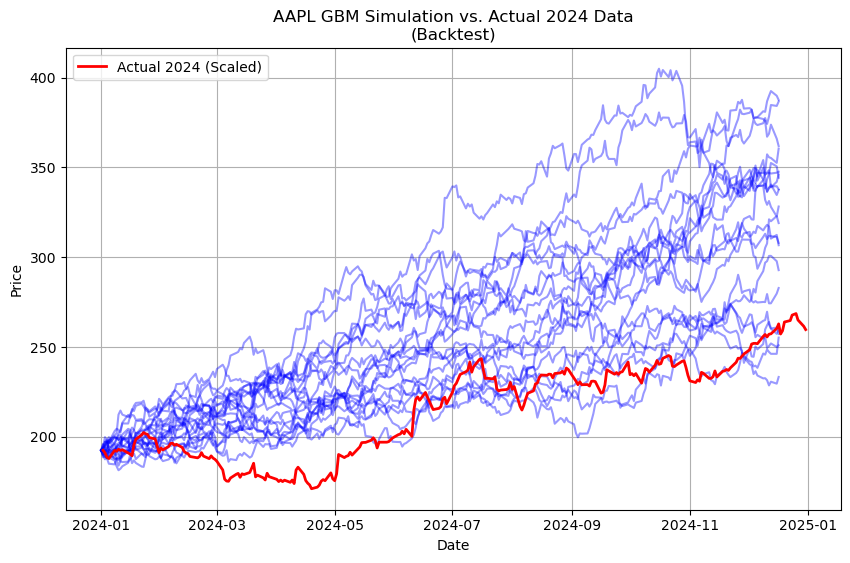

=== Simulation Summary (Final Day) ===
Simulated final day average: 303.08
Simulated final day median:  297.01
Simulated final day min:     126.65
Simulated final day max:     695.24

=== Actual vs. Simulated (Scaled to 2023 Close) ===
Final actual price (scaled)  : 259.71
Mean simulated final price   : 303.08
Difference (actual - mean)   : -43.37


In [49]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_and_backtest(
    ticker="AAPL",
    historical_start="2023-01-01",
    historical_end="2023-12-31",
    real_start="2024-01-01",
    real_end="2025-01-01",
    num_simulations=1000,
    days_to_simulate=252
):
    """
    1) Fetch historical data for the given ticker and date range (2023) to estimate mu, sigma.
    2) Simulate stock price for 2024 using a Geometric Brownian Motion model.
    3) Fetch the actual data for 2024 (real_start to real_end).
    4) Plot the simulated paths and compare them to the actual 2024 data.
    """

    #-------------------------------------------------------------------------
    # 1. Fetch historical data for 2023 to derive GBM parameters
    #-------------------------------------------------------------------------
    hist_data = yf.download(ticker, start=historical_start, end=historical_end, progress=False)
    if hist_data.empty:
        raise ValueError(f"No historical data returned for {ticker} in {historical_start} to {historical_end}.")

    # Compute daily returns
    hist_data['Daily_Returns'] = hist_data['Close'].pct_change()
    hist_data.dropna(inplace=True)
    
    mu = hist_data['Daily_Returns'].mean()
    sigma = hist_data['Daily_Returns'].std()

    # Last known price of 2023
    last_price_2023 = hist_data['Close'].iloc[-1]

    #-------------------------------------------------------------------------
    # 2. Simulate stock price for 2024 using Geometric Brownian Motion
    #-------------------------------------------------------------------------
    dt = 1.0  # 1 step = 1 trading day
    price_paths = np.zeros((days_to_simulate, num_simulations))
    price_paths[0, :] = last_price_2023

    for t in range(1, days_to_simulate):
        Z = np.random.standard_normal(num_simulations)
        price_paths[t, :] = price_paths[t-1, :] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        )

    #-------------------------------------------------------------------------
    # 3. Fetch actual data for 2024
    #-------------------------------------------------------------------------
    real_data_2024 = yf.download(ticker, start=real_start, end=real_end, progress=False)
    if real_data_2024.empty:
        raise ValueError(f"No actual 2024 data returned for {ticker} in {real_start} to {real_end}.")

    # Since we want to compare the real 2024 series to our simulated paths
    # that start at 'last_price_2023', we can "scale" the real data so that
    # its first day in 2024 starts at last_price_2023.
    # E.g.:
    real_data_2024['Scaled_Close'] = (
        real_data_2024['Close'] / real_data_2024['Close'].iloc[0] * last_price_2023
    )

    #-------------------------------------------------------------------------
    # 4. Plot the simulated paths + actual data
    #-------------------------------------------------------------------------
    plt.figure(figsize=(10, 6))

    # Create a date range for our simulated paths (approx. business days)
    # so we can plot them next to real data on the same x-axis.
    simulation_dates = pd.bdate_range(start=real_start, periods=days_to_simulate)

    # Plot a subset of simulations to avoid clutter
    for i in range(min(num_simulations, 20)):  # plot up to 20
        plt.plot(simulation_dates, price_paths[:, i], alpha=0.4, color='blue')

    # Plot the actual scaled close data
    plt.plot(real_data_2024.index, real_data_2024['Scaled_Close'], 
             label="Actual 2024 (Scaled)", 
             color='red', 
             linewidth=2)

    plt.title(f"{ticker} GBM Simulation vs. Actual 2024 Data\n(Backtest)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()

    #-------------------------------------------------------------------------
    # Print some summary or insight
    #-------------------------------------------------------------------------
    final_sim_prices = price_paths[-1, :]
    print("=== Simulation Summary (Final Day) ===")
    print(f"Simulated final day average: {final_sim_prices.mean():.2f}")
    print(f"Simulated final day median:  {np.median(final_sim_prices):.2f}")
    print(f"Simulated final day min:     {final_sim_prices.min():.2f}")
    print(f"Simulated final day max:     {final_sim_prices.max():.2f}")

    # Show how the actual ended vs. the average simulation
    actual_final = real_data_2024['Scaled_Close'].iloc[-1]
    print("\n=== Actual vs. Simulated (Scaled to 2023 Close) ===")
    print(f"Final actual price (scaled)  : {actual_final:.2f}")
    print(f"Mean simulated final price   : {final_sim_prices.mean():.2f}")
    print(f"Difference (actual - mean)   : {actual_final - final_sim_prices.mean():.2f}")
    print("=============================================")


if __name__ == "__main__":
    simulate_and_backtest(
        ticker="AAPL",
        historical_start="2023-01-01",
        historical_end="2023-12-31",
        real_start="2024-01-01",
        real_end="2025-01-01",  # or "2024-12-31" if you prefer
        num_simulations=100000,
        days_to_simulate=252
    )


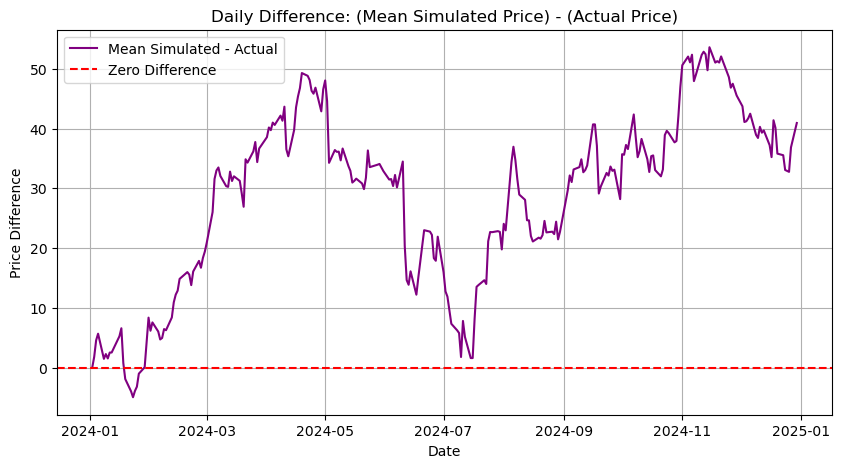

=== Differences Statistics ===
Mean difference  : 28.61
Std of difference: 14.45
Max difference   : 53.64
Min difference   : -4.98


In [52]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Single-cell code: fetch data, simulate fresh paths, compare, and plot differences.
# ---------------------------------------------------------------------------------
ticker = "AAPL"
historical_start = "2023-01-01"
historical_end   = "2023-12-31"
real_start       = "2024-01-01"
real_end         = "2024-12-31"
num_simulations  = 100000

# 1) Fetch AAPL data for 2023 and compute mu, sigma
hist_data = yf.download(ticker, start=historical_start, end=historical_end, progress=False)
hist_data['Daily_Returns'] = hist_data['Close'].pct_change()
hist_data.dropna(inplace=True)

mu = hist_data['Daily_Returns'].mean()
sigma = hist_data['Daily_Returns'].std()

last_2023_close = hist_data['Close'].iloc[-1]

# 2) Fetch actual 2024 data
real_data_2024 = yf.download(ticker, start=real_start, end=real_end, progress=False)
if real_data_2024.empty:
    raise ValueError(f"No actual 2024 data returned for {ticker} in {real_start} to {real_end}.")

# 3) Scale the 2024 actual data so that day 1 of 2024 starts where 2023 left off
real_data_2024['Scaled_Close'] = (
    real_data_2024['Close'] / real_data_2024['Close'].iloc[0] * last_2023_close
)

# 4) Use the same number of dates in real_data_2024 to simulate day-by-day alignment
simulation_dates = real_data_2024.index
days_to_simulate = len(simulation_dates)

# 5) Simulate new Brownian paths (Geometric Brownian Motion)
dt = 1.0  # 1 step = 1 trading day
price_paths = np.zeros((days_to_simulate, num_simulations))
price_paths[0, :] = last_2023_close  # all paths start at the last 2023 close

for t in range(1, days_to_simulate):
    Z = np.random.standard_normal(num_simulations)
    price_paths[t, :] = price_paths[t - 1, :] * np.exp(
        (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    )

# 6) Compute the average predicted price at each day t
predicted_averages = price_paths.mean(axis=1)  # shape: (days_to_simulate,)

# 7) Compute differences: (mean simulated) - (actual scaled)
actual_values = real_data_2024['Scaled_Close'].values
differences = predicted_averages - actual_values

# 8) Plot the evolution of differences
plt.figure(figsize=(10, 5))
plt.plot(simulation_dates, differences, label="Mean Simulated - Actual", color="purple")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Difference")
plt.title("Daily Difference: (Mean Simulated Price) - (Actual Price)")
plt.xlabel("Date")
plt.ylabel("Price Difference")
plt.legend()
plt.grid(True)
plt.show()

# 9) Print statistics about the differences
print("=== Differences Statistics ===")
print(f"Mean difference  : {differences.mean():.2f}")
print(f"Std of difference: {differences.std():.2f}")
print(f"Max difference   : {differences.max():.2f}")
print(f"Min difference   : {differences.min():.2f}")



In [ ]:
#Next is the function 


In [53]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime

def backtest_gbm(
    ticker: str,
    hist_start_str: str,
    hist_end_str: str,
    real_start_str: str,
    real_end_str: str,
    num_simulations: int = 1000
):
    """
    1) Fetch historical data for 'ticker' between [hist_start, hist_end] to estimate mu, sigma.
    2) Fetch actual data for 'ticker' between [real_start, real_end] to compare with simulations.
    3) Simulate stock price paths for the real-data period using a Geometric Brownian Motion (GBM).
    4) Return:
       - price_paths: ndarray of shape (days, num_simulations),
       - predicted_averages: ndarray of shape (days,),
       - actual_scaled: ndarray of shape (days,),
       - differences: ndarray of shape (days,).
    
    Args:
        ticker (str): Stock ticker symbol, e.g. "AAPL".
        hist_start_str (str): Historical start date in dd-mm-yyyy format, e.g. "01-01-2023".
        hist_end_str   (str): Historical end   date in dd-mm-yyyy format, e.g. "31-12-2023".
        real_start_str (str): Real (forward) period start in dd-mm-yyyy format, e.g. "01-01-2024".
        real_end_str   (str): Real (forward) period end   in dd-mm-yyyy format, e.g. "31-12-2024".
        num_simulations (int): Number of GBM simulations to run.
    
    Returns:
        tuple of:
            price_paths       (ndarray): Simulated price matrix (days x num_simulations)
            predicted_averages(ndarray): Daily mean of simulated prices (days,)
            actual_scaled     (ndarray): The actual scaled close prices for the real period (days,)
            differences       (ndarray): predicted_averages - actual_scaled (days,)
    """

    # Helper function to parse dd-mm-yyyy into YYYY-MM-DD
    def parse_date(date_str):
        # date_str is in "dd-mm-yyyy" => we convert to "yyyy-mm-dd"
        day, month, year = date_str.split("-")
        return f"{year}-{month}-{day}"

    # Parse the input date strings into YYYY-MM-DD
    hist_start = parse_date(hist_start_str)
    hist_end   = parse_date(hist_end_str)
    real_start = parse_date(real_start_str)
    real_end   = parse_date(real_end_str)

    # -----------------------------
    # 1) Fetch historical data (for mu, sigma)
    # -----------------------------
    hist_data = yf.download(ticker, start=hist_start, end=hist_end, progress=False)
    if hist_data.empty:
        raise ValueError(f"No historical data returned for {ticker} in [{hist_start}, {hist_end}]")

    # Compute daily returns and drop the initial NaN
    hist_data['Daily_Returns'] = hist_data['Close'].pct_change()
    hist_data.dropna(inplace=True)

    mu = hist_data['Daily_Returns'].mean()
    sigma = hist_data['Daily_Returns'].std()

    # Last known price from the historical data
    last_price_of_hist = hist_data['Close'].iloc[-1]

    # -----------------------------
    # 2) Fetch actual data (for comparison period)
    # -----------------------------
    real_data = yf.download(ticker, start=real_start, end=real_end, progress=False)
    if real_data.empty:
        raise ValueError(f"No real data returned for {ticker} in [{real_start}, {real_end}]")

    # Scale the real data so that the first day matches the last historical close
    real_data['Scaled_Close'] = (
        real_data['Close'] / real_data['Close'].iloc[0] * last_price_of_hist
    )

    # We'll align the simulation's day count to the length of real_data
    simulation_dates = real_data.index
    days_to_simulate = len(simulation_dates)

    # -----------------------------
    # 3) Simulate new Brownian paths (GBM) for the real-data period
    # -----------------------------
    dt = 1.0  # 1 step = 1 trading day
    price_paths = np.zeros((days_to_simulate, num_simulations))
    price_paths[0, :] = last_price_of_hist

    for t in range(1, days_to_simulate):
        Z = np.random.standard_normal(num_simulations)
        price_paths[t, :] = price_paths[t - 1, :] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        )

    # -----------------------------
    # 4) Compute daily average of simulated paths, actual data, and differences
    # -----------------------------
    predicted_averages = price_paths.mean(axis=1)              # shape: (days,)
    actual_scaled      = real_data['Scaled_Close'].values      # shape: (days,)
    differences        = predicted_averages - actual_scaled    # shape: (days,)

    # Return all the arrays of interest
    return price_paths, predicted_averages, actual_scaled, differences


In [112]:
paths, avg_sim, actual, diff = backtest_gbm(
    ticker="NVDA",
    hist_start_str="20-01-2023",
    hist_end_str="31-12-2023",
    real_start_str="01-01-2024",
    real_end_str="04-01-2025",
    num_simulations=1000
)


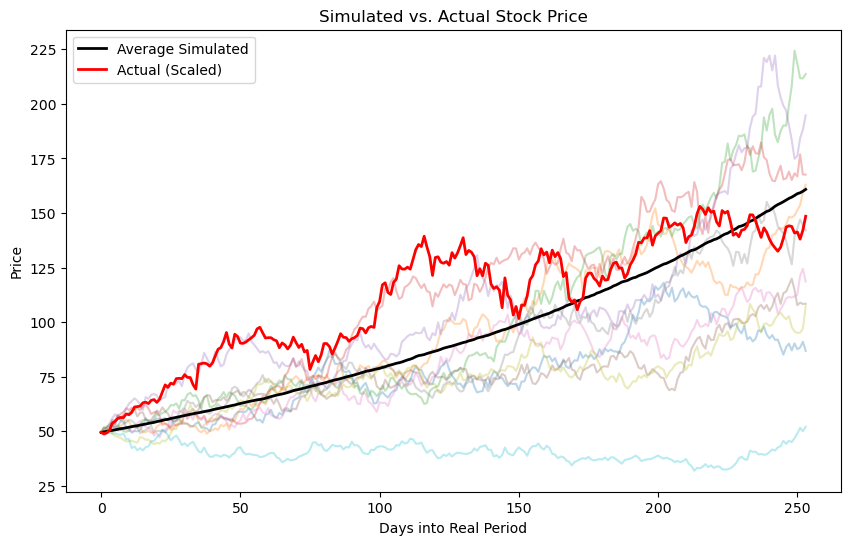

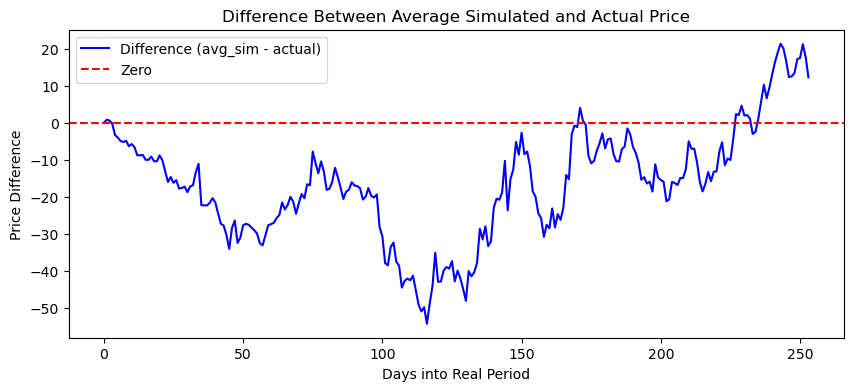

In [113]:
import matplotlib.pyplot as plt

# Plot a few simulated paths
plt.figure(figsize=(10, 6))
for i in range(10):  # just plot 10 paths to avoid clutter
    plt.plot(paths[:, i], alpha=0.3)
plt.plot(avg_sim, 'k', linewidth=2, label='Average Simulated')
plt.plot(actual, 'r', linewidth=2, label='Actual (Scaled)')
plt.title("Simulated vs. Actual Stock Price")
plt.xlabel("Days into Real Period")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot differences
plt.figure(figsize=(10, 4))
plt.plot(diff, 'b', label="Difference (avg_sim - actual)")
plt.axhline(0, color='r', linestyle='--', label="Zero")
plt.title("Difference Between Average Simulated and Actual Price")
plt.xlabel("Days into Real Period")
plt.ylabel("Price Difference")
plt.legend()
plt.show()


In [100]:
#now we test another variation of this fct that uses different training windows


In [101]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def gbm_with_varied_subsets(
    ticker: str,
    hist_start_str: str,
    hist_end_str: str,
    real_start_str: str,
    real_end_str: str,
    subset_days_list: list,
    num_simulations: int = 100
):
    """
    1) Fetch full historical data for the entire hist_start->hist_end range.
       We'll compute multiple (mu, sigma) pairs by taking the last 'd' days 
       from the historical data for each d in subset_days_list.
    2) Fetch real data for real_start->real_end and scale it so the first day 
       aligns with the last close of the historical data.
    3) For each subset size:
       a) Extract that slice of historical data,
       b) Compute mu, sigma,
       c) Simulate GBM for the forward (real) period.
       d) Plot all simulated paths for that subset and their average path.
    4) Compute the 'average of average paths' across all subsets and plot it too.
    5) Plot the actual (scaled) data in a distinctive color for comparison.
    
    Args:
        ticker (str): Stock symbol, e.g. "AAPL".
        hist_start_str (str): Historical data start date in "dd-mm-yyyy".
        hist_end_str   (str): Historical data end   date in "dd-mm-yyyy".
        real_start_str (str): Forward period start in "dd-mm-yyyy".
        real_end_str   (str): Forward period end   in "dd-mm-yyyy".
        subset_days_list (list): List of integers, each indicating 
                                 how many of the 'last days' to use 
                                 for computing mu, sigma. E.g. [10, 30, 60, 365].
        num_simulations (int): Number of GBM paths to simulate per subset.
        
    Returns:
        A dictionary with keys:
          {
            'all_price_paths': dict of {subset_days: 2D array (days x num_simulations)},
            'all_avg_paths':   dict of {subset_days: 1D array (days,)},
            'ensemble_avg':    1D array (days,) of the average of averages,
            'actual_scaled':   1D array (days,) of real scaled close,
            'simulation_dates': DatetimeIndex of length (days,).
          }
    """

    # Helper: parse dd-mm-yyyy into yyyy-mm-dd
    def parse_date(date_str):
        day, month, year = date_str.split("-")
        return f"{year}-{month}-{day}"
    
    # Parse input strings
    hist_start = parse_date(hist_start_str)
    hist_end   = parse_date(hist_end_str)
    real_start = parse_date(real_start_str)
    real_end   = parse_date(real_end_str)

    # --------------------------------------------------------------------
    # 1) Fetch the full historical data over hist_start->hist_end
    # --------------------------------------------------------------------
    hist_data = yf.download(ticker, start=hist_start, end=hist_end, progress=False)
    if hist_data.empty:
        raise ValueError(f"No historical data returned for {ticker} [{hist_start}, {hist_end}]")
    
    # Compute daily returns for the entire historical dataset
    hist_data['Daily_Returns'] = hist_data['Close'].pct_change()
    hist_data.dropna(inplace=True)

    # We'll need the "last close" from the historical period to anchor the forward scaling
    last_hist_close = hist_data['Close'].iloc[-1]
    
    # --------------------------------------------------------------------
    # 2) Fetch real data and scale it so day 1 lines up with last_hist_close
    # --------------------------------------------------------------------
    real_data = yf.download(ticker, start=real_start, end=real_end, progress=False)
    if real_data.empty:
        raise ValueError(f"No real data returned for {ticker} [{real_start}, {real_end}]")
    
    real_data['Scaled_Close'] = (
        real_data['Close'] / real_data['Close'].iloc[0] * last_hist_close
    )
    
    simulation_dates = real_data.index
    days_to_simulate = len(simulation_dates)
    actual_scaled = real_data['Scaled_Close'].values  # shape: (days,)

    # --------------------------------------------------------------------
    # We'll store results for each subset
    # --------------------------------------------------------------------
    all_price_paths = {}  # subset_days -> 2D array of shape (days, num_simulations)
    all_avg_paths   = {}  # subset_days -> 1D array of shape (days,)

    # Prepare color cycling
    color_cycle = plt.cm.tab10(np.linspace(0, 1, len(subset_days_list)))

    plt.figure(figsize=(12, 7))
    
    # --------------------------------------------------------------------
    # 3) For each subset size in subset_days_list, re-estimate mu,sigma & simulate
    # --------------------------------------------------------------------
    for idx, subset_days in enumerate(subset_days_list):
        # 3a) Extract the last 'subset_days' from historical data
        #     If subset_days is larger than available data, we can clamp it.
        subset_days = min(subset_days, len(hist_data))
        subset_data = hist_data.iloc[-subset_days:]

        # 3b) Compute mu, sigma
        mu = subset_data['Daily_Returns'].mean()
        sigma = subset_data['Daily_Returns'].std()

        # 3c) Simulate with GBM
        dt = 1.0
        price_paths = np.zeros((days_to_simulate, num_simulations))
        price_paths[0, :] = last_hist_close

        for t in range(1, days_to_simulate):
            Z = np.random.standard_normal(num_simulations)
            price_paths[t, :] = price_paths[t-1, :] * np.exp(
                (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
            )

        # Store these paths
        all_price_paths[subset_days] = price_paths

        # 3d) Compute the average path
        avg_path = price_paths.mean(axis=1)
        all_avg_paths[subset_days] = avg_path

        # Plot the simulations in a lighter color, plus the average path in a thicker line
        # (so each subset has a distinctive color).
        color = color_cycle[idx]
        label_sim = f"Sub={subset_days} days (sim)"
        label_avg = f"Sub={subset_days} days (avg)"

        # Plot *some* of the simulation paths (to avoid clutter, e.g., up to 3)
        for s in range(min(num_simulations, 3)):
            plt.plot(simulation_dates, price_paths[:, s], color=color, alpha=0.15)

        # Plot the average path in the same color, more visible
        plt.plot(simulation_dates, avg_path, color=color, linewidth=2, label=label_avg)

    # --------------------------------------------------------------------
    # 4) Compute the average of all "average paths"
    # --------------------------------------------------------------------
    # We'll have one average path per subset. Let's gather them:
    subset_avg_values = np.array(list(all_avg_paths.values()))  # shape: (N_subsets, days)
    ensemble_avg = subset_avg_values.mean(axis=0)               # shape: (days,)

    # Plot the ensemble average in black (thicker line)
    plt.plot(simulation_dates, ensemble_avg, color="black", linewidth=3, 
             label="Ensemble Avg of All Subset Averages")

    # --------------------------------------------------------------------
    # 5) Plot the actual scaled data in red
    # --------------------------------------------------------------------
    plt.plot(simulation_dates, actual_scaled, color="red", linewidth=2, 
             label="Actual (Scaled)")

    plt.title(f"GBM with Varied Training Windows - {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return a dictionary of all computed data for further analysis if desired
    return {
        "all_price_paths": all_price_paths,
        "all_avg_paths":   all_avg_paths,
        "ensemble_avg":    ensemble_avg,
        "actual_scaled":   actual_scaled,
        "simulation_dates": simulation_dates
    }


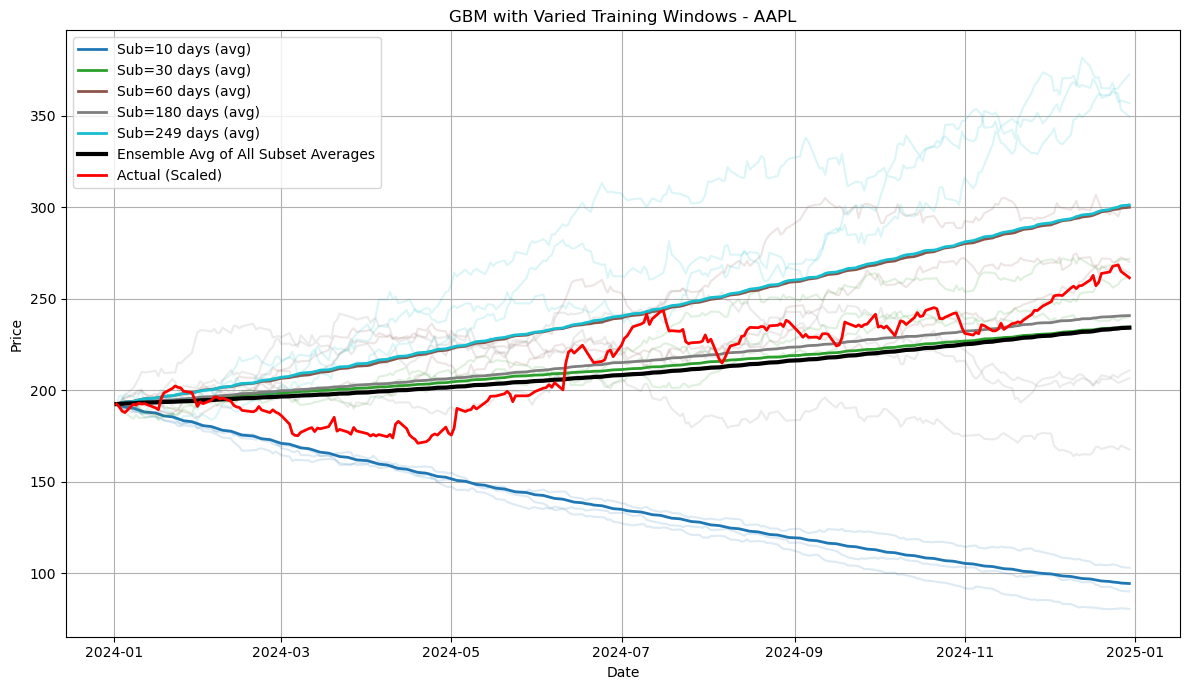

In [114]:
results = gbm_with_varied_subsets(
    ticker="AAPL",
    hist_start_str="01-01-2023",
    hist_end_str="31-12-2023",
    real_start_str="01-01-2024",
    real_end_str="31-12-2024",
    subset_days_list=[10, 30, 60, 180, 365],
    num_simulations=1000
)


In [ ]:
#here is another function that uses GARGH

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

def backtest_arima(
    ticker: str,
    hist_start_str: str,
    hist_end_str: str,
    real_start_str: str,
    real_end_str: str,
    order: tuple = (1,0,0),
    num_simulations: int = 1000
):
    """
    1) Download historical data for [hist_start, hist_end].
       - Compute daily returns and fit an ARIMA model of given order (p,d,q).
    2) Download real 'out-of-sample' data for [real_start, real_end].
       - We'll simulate the same number of days as in the out-of-sample period.
    3) Generate multiple simulated price paths by drawing from the
       ARIMA forecast distribution each day. Paths all start at the
       final historical close.
    4) Scale the real data so that the first out-of-sample day aligns
       with the last historical close.
    5) Return:
       - price_paths       (ndarray): shape (days, num_simulations)
       - predicted_averages(ndarray): shape (days,)
       - actual_scaled     (ndarray): shape (days,)
       - differences       (ndarray): shape (days,)

    Args:
        ticker (str)            : e.g. "AAPL".
        hist_start_str (str)    : Historical start (dd-mm-yyyy).
        hist_end_str   (str)    : Historical end   (dd-mm-yyyy).
        real_start_str (str)    : Out-of-sample start (dd-mm-yyyy).
        real_end_str   (str)    : Out-of-sample end   (dd-mm-yyyy).
        order (tuple)           : ARIMA(p,d,q) order, e.g. (1,0,0).
        num_simulations (int)   : Number of ARIMA-based simulations.
    """

    # Helper: parse "dd-mm-yyyy" into "yyyy-mm-dd"
    def parse_date(date_str):
        day, month, year = date_str.split("-")
        return f"{year}-{month}-{day}"

    # Parse input strings into yyyy-mm-dd for yfinance
    hist_start = parse_date(hist_start_str)
    hist_end   = parse_date(hist_end_str)
    real_start = parse_date(real_start_str)
    real_end   = parse_date(real_end_str)

    # --------------------------------------------------------------------
    # 1) Fetch historical data and fit ARIMA
    # --------------------------------------------------------------------
    hist_data = yf.download(ticker, start=hist_start, end=hist_end, progress=False)
    if hist_data.empty:
        raise ValueError(f"No historical data returned for {ticker} in [{hist_start}, {hist_end}].")

    # Compute daily returns (you might also consider log-returns)
    hist_data['Returns'] = hist_data['Close'].pct_change()
    hist_data.dropna(inplace=True)  # drop the initial NaN
    returns_series = hist_data['Returns']

    # Fit ARIMA model to the daily returns
    # For example, order=(1,0,0) is AR(1), order=(1,1,0) would be ARIMA with one differencing, etc.
    arima_model = ARIMA(returns_series, order=order)
    arima_res = arima_model.fit()

    # The last historical close to anchor the forward simulations
    last_hist_close = hist_data['Close'].iloc[-1]

    # --------------------------------------------------------------------
    # 2) Fetch out-of-sample (future) data
    # --------------------------------------------------------------------
    real_data = yf.download(ticker, start=real_start, end=real_end, progress=False)
    if real_data.empty:
        raise ValueError(f"No real data returned for {ticker} in [{real_start}, {real_end}].")

    # We'll align the simulation with the number of dates in real_data
    simulation_dates = real_data.index
    days_to_simulate = len(simulation_dates)

    # --------------------------------------------------------------------
    # 3) Multi-step forecast from ARIMA
    # --------------------------------------------------------------------
    # We get multi-step forecasts of returns. ARIMA provides the *mean* forecast.
    # We'll also assume a constant residual std dev from the model's sigma2 (variance).
    # This is a simplification: in practice, you'd retrieve each step's forecast variance or do iterative forecasting.

    # 3a) Mean forecast for the next 'days_to_simulate' returns
    forecast_res = arima_res.get_forecast(steps=days_to_simulate)
    mean_forecast = forecast_res.predicted_mean.values  # shape: (days_to_simulate,)

    # 3b) We'll get an approximate residual variance (sigma^2). 
    # A simpler approach is to take the in-sample residual variance from the fitted model
    residual_var = arima_res.resid.var()
    residual_std = np.sqrt(residual_var)

    # 3c) Generate multiple price paths
    price_paths = np.zeros((days_to_simulate, num_simulations))
    price_paths[0, :] = last_hist_close  # day 0 of out-of-sample

    for i in range(num_simulations):
        for t in range(1, days_to_simulate):
            # Forecasted daily return's mean
            mu_t = mean_forecast[t]
            # Random draw around that mean with the ARIMA residual std dev
            rt = np.random.normal(loc=mu_t, scale=residual_std)
            # Convert that daily return to a price update
            price_paths[t, i] = price_paths[t - 1, i] * (1 + rt)

    # --------------------------------------------------------------------
    # 4) Scale the real data so that out-of-sample day 1 starts at last_hist_close
    # --------------------------------------------------------------------
    real_data['Scaled_Close'] = (
        real_data['Close'] / real_data['Close'].iloc[0] * last_hist_close
    )
    actual_scaled = real_data['Scaled_Close'].values  # shape: (days_to_simulate,)

    # --------------------------------------------------------------------
    # 5) Compute average simulated path and difference
    # --------------------------------------------------------------------
    predicted_averages = price_paths.mean(axis=1)  # shape: (days,)
    differences = predicted_averages - actual_scaled

    return price_paths, predicted_averages, actual_scaled, differences


# ----------------------------------------------------------------------------


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users

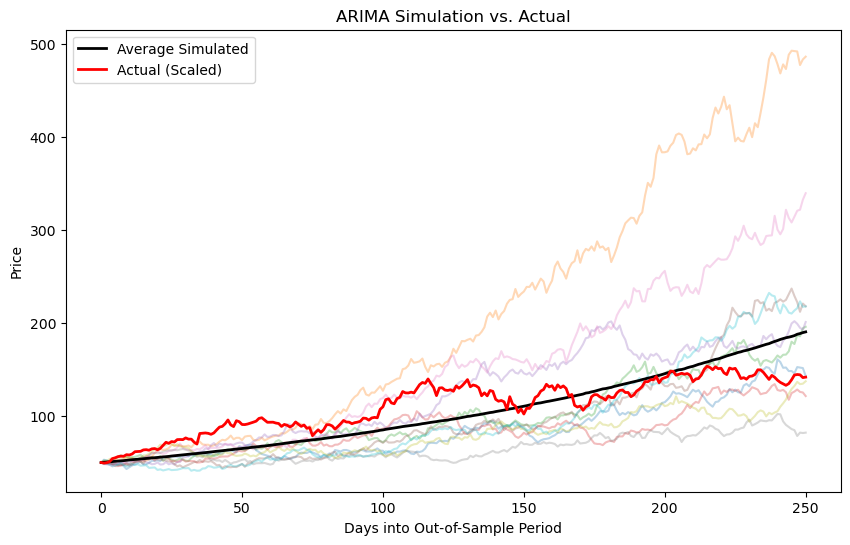

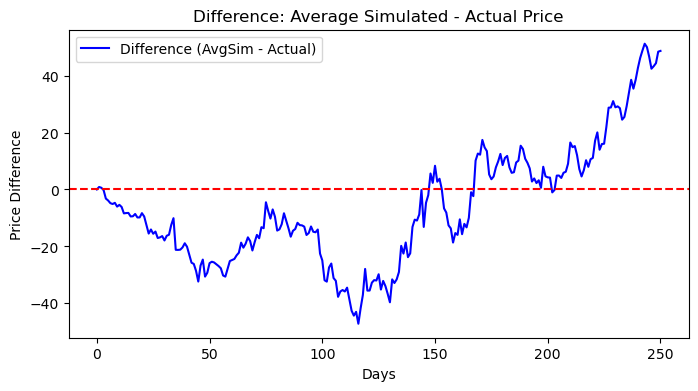

In [8]:


if __name__ == "__main__":
    paths, avg_sim, actual, diff = backtest_arima(
        ticker="NVDA",
        hist_start_str="01-01-2023",
        hist_end_str="31-12-2023",
        real_start_str="01-01-2024",
        real_end_str="31-12-2024",
        order=(1,0,0),      # AR(1) for returns, as an example
        num_simulations=1000
    )

    # Quick plot
    plt.figure(figsize=(10,6))
    # Plot a few simulated paths
    for i in range(10):
        plt.plot(paths[:, i], alpha=0.3)
    # Plot the average
    plt.plot(avg_sim, 'k', linewidth=2, label='Average Simulated')
    # Plot actual
    plt.plot(actual, 'r', linewidth=2, label='Actual (Scaled)')
    plt.title("ARIMA Simulation vs. Actual")
    plt.xlabel("Days into Out-of-Sample Period")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Differences
    plt.figure(figsize=(8,4))
    plt.plot(diff, 'b', label="Difference (AvgSim - Actual)")
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Difference: Average Simulated - Actual Price")
    plt.xlabel("Days")
    plt.ylabel("Price Difference")
    plt.legend()
    plt.show()